Data is from Yelp - https://www.yelp.com/dataset/documentation/main

# Ideas
- Create a corpus of reviews from top reviewers
  - try to predict ratings based on review nlp
    - use ANN or LSTM to asses review classifier prediction.
    - calculate error of ML rating vs actual rating. 
      - see if there is an argument for an adjusted rating as there are too many 5 star reviews.. 

- Create clusters of reviewers on particular metrics to find similarities or elite reviewers in the making. 
  - Do this based on review NLP metrics, are they using language of top reviewers
  - maybe include a ration of reviews / fans in as a feature to normalize. 
  - 
- After training, consider adding a chatbot trained on reviews. 

- stars can be a target variable
- techniques to consider - bag of words , tf- idf, word2vec
- for lstm - over 100 words is a good threshold 
- consider the frequency dist of words in the dataset - sort by lemm
- train models by city / category
- look at confusion matrix on models that are by city vs all cities model. 
- clean docs in whole prior to slicing for tf-idf / vectorizaion (word2vec)

## Imports,

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from nltk.corpus import stopwords
import spacy

from collections import Counter
import nltk
import spacy
import re

from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('gutenberg')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [3]:
!python -m spacy download en --quiet

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
def clean_cats(x):
  tokens = word_tokenize(x)
  cleaned_tokens = [token.lower() for token in tokens if token.lower() not in stopwords.words('english') if token.isalpha()] # is alpha is only A-Z
  sorted_tokens = sorted(cleaned_tokens)
  return ' '.join(sorted_tokens)

## Download Data and perform basic EDA, and Merge DataFrames
- Biz Data
- User Data
- Review Data

In [5]:
data = {'business_id': [], 'name':[], 'city': [], 'stars':[], 'review_count': [], 'categories': []}


with open('/content/drive/MyDrive/Colab Notebooks/Yelp_dataset/yelp_academic_dataset_business.json') as f:
  for line in tqdm(f):
    review = json.loads(line)
    data['business_id'].append(review['business_id'])
    data['name'].append(review['name'])
    data['city'].append(review['city'])
    data['stars'].append(review['stars'])
    data['review_count'].append(review['review_count'])
    data['categories'].append(review['categories'])

biz_df = pd.DataFrame(data)
biz_df.info()

160585it [00:02, 74254.08it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160585 entries, 0 to 160584
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   160585 non-null  object 
 1   name          160585 non-null  object 
 2   city          160585 non-null  object 
 3   stars         160585 non-null  float64
 4   review_count  160585 non-null  int64  
 5   categories    160470 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 7.4+ MB


In [6]:
biz_df[biz_df.business_id == 'ISBs1ARjIFCXGWqPmGSMog']

,business_id,name,city,stars,review_count,categories
7149,ISBs1ARjIFCXGWqPmGSMog,Massage Envy - Needham Street,Newton,3.0,47,"Massage Therapy, Beauty & Spas, Massage, Skin ..."


In [7]:
biz_df.isna().sum()

business_id       0
name              0
city              0
stars             0
review_count      0
categories      115
dtype: int64

In [8]:
biz_df = biz_df.dropna()

In [9]:
data = {'review_id':[], 'user_id': [],'business_id': [], 'stars':[], 'text': [], 'useful': [], 'funny': [], 'cool': []}

with open('/content/drive/MyDrive/Colab Notebooks/Yelp_dataset/yelp_academic_dataset_review.json') as f:
  for line in tqdm(f):
    review = json.loads(line)
    data['review_id'].append(review['review_id'])
    data['user_id'].append(review['user_id'])
    data['business_id'].append(review['business_id'])
    data['stars'].append(review['stars'])
    data['text'].append(review['text'])
    data['useful'].append(review['useful'])
    data['funny'].append(review['funny'])
    data['cool'].append(review['cool'])

rev_df = pd.DataFrame(data)
rev_df.info()

8635403it [01:36, 89227.06it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8635403 entries, 0 to 8635402
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   text         object 
 5   useful       int64  
 6   funny        int64  
 7   cool         int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 527.1+ MB


In [10]:
data = {'user_id': [],'review_count': [], 'fans':[], 'average_stars': []}
#data = {'business_id': []}

with open('/content/drive/MyDrive/Colab Notebooks/Yelp_dataset/yelp_academic_dataset_user.json') as f:
  for line in tqdm(f):
    review = json.loads(line)
    data['user_id'].append(review['user_id'])
    data['review_count'].append(review['review_count'])
    data['fans'].append(review['fans'])
    data['average_stars'].append(review['average_stars'])
  

user_df = pd.DataFrame(data)
user_df.info()

2189457it [00:53, 40731.61it/s] 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189457 entries, 0 to 2189456
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   review_count   int64  
 2   fans           int64  
 3   average_stars  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 66.8+ MB


In [11]:
df = rev_df.merge(user_df, on = 'user_id', how = 'left').merge(biz_df, on = 'business_id', how = 'left')


In [12]:
df = df.dropna()
df.isna().sum()

review_id         0
user_id           0
business_id       0
stars_x           0
text              0
useful            0
funny             0
cool              0
review_count_x    0
fans              0
average_stars     0
name              0
city              0
stars_y           0
review_count_y    0
categories        0
dtype: int64

In [13]:
df = df.sample(frac = .01, replace = 'disallow')
df.shape

(86345, 16)

In [14]:
# Clean df - rename columns, drop unneeded columns

df['cur_review_star'] = df['stars_x']
df['user_rev_sum'] = df['review_count_x']
df['biz_name'] = df['name']
df['user_avg_star'] = df['average_stars']
df['biz_star'] = df['stars_y']
df['biz_rev_sum'] = df['review_count_y']
df['rev_fb'] = (df['useful'] + df['funny'] + df['cool']) # summing positive feedback actions from other users.
df['clean_cats'] = df.categories.apply(clean_cats) 
df['star_diff'] = (df['cur_review_star'] - df['biz_star'])/ df['user_avg_star'] # did user give a boost or decline to biz star avg. 
df['fb_ratio'] = (df['rev_fb']+.01) / np.abs(df['star_diff']+.01) # Get a normalized metric for how valuable the review is to the readers.  

df = df.drop(columns= [
                       'fans',
                       'stars_x',
                       'review_count_x',
                       'name',
                       'average_stars',
                       'stars_y',
                       'review_count_y',
                       'categories',
                       'useful',
                       'funny',
                       'cool',
                       
                       ])

In [15]:
df.head()

,review_id,user_id,business_id,text,city,cur_review_star,user_rev_sum,biz_name,user_avg_star,biz_star,biz_rev_sum,rev_fb,clean_cats,star_diff,fb_ratio
689362,VnSwjfIYRjOivS6RLGcbww,J_F9RgMgNDZMpIVdJ-sxQQ,Wm9MxV0tCwNP3z4HR__PUQ,Great prices. Very bad service. Asked for help...,Milwaukie,1.0,2,Lowe's Home Improvement,1.50,2.0,107.0,0,appliances appliances building garden gardenin...,-0.666667,0.015228
8432864,ROVXmo_hZ_S3zgQxAJc34A,xFdiU-lvqvY0isZR09ZFyA,HiKaOq-qOFNzHn-XGrI1eQ,These guys are great! Only took about an hour ...,Quincy,5.0,4,Jimmy's Tire,4.00,5.0,48.0,0,automotive tires,0.000000,1.000000
130363,4bJ7drQCFnFzXV3Aibgsaw,9CgfWqYjpN_toFTwmvxdlg,MtkKB14JlKIyIej540Rdvw,The Local is probably one of the bars/restaura...,Atlanta,4.0,2,The Local,4.00,4.0,308.0,1,bars nightlife restaurants,0.000000,101.000000
4591455,Y-FExqebAILWrUZPwHSDxQ,ZH2XsQfceXTYbwX0mHlMgw,NYcU7zKYvb7H5_FmNWNn0w,This and it's lil brother are the NEW hotness ...,Waltham,5.0,71,Molti On Moody,4.37,4.0,460.0,0,breakfast brunch delis food food meat restaura...,0.228833,0.041870
263416,WraQOf2s8detmO0YQSBKWg,_HiI0WhqKegnZRg5OW-s_Q,-oCYfB-JL3Yc_RECg4B1Qw,Delicious. These are often brought to work an...,Austin,5.0,76,Voodoo Doughnut - 6th Street,3.81,3.5,1809.0,0,bakeries chapels donuts event food planning se...,0.393701,0.024771


In [16]:
df.shape

(86345, 15)

In [17]:
df.to_csv('merged_data.csv', index = False)
!cp merged_data.csv '/content/drive/MyDrive/Colab Notebooks/Yelp NLP Project'

In [18]:
df.describe()

,cur_review_star,user_rev_sum,user_avg_star,biz_star,biz_rev_sum,rev_fb,star_diff,fb_ratio
count,86345.000000,86345.000000,86345.000000,86345.000000,86345.000000,86345.000000,86345.000000,86345.000000
mean,3.728728,138.250611,3.731968,3.734466,372.904372,2.171313,-0.069417,41.762980
std,1.461515,538.132681,0.816647,0.730274,701.640917,6.312801,0.510204,295.522240
min,1.000000,1.000000,1.000000,1.000000,5.000000,0.000000,-4.000000,0.002506
25%,3.000000,8.000000,3.400000,3.500000,52.000000,0.000000,-0.235294,0.044525
50%,4.000000,26.000000,3.840000,4.000000,158.000000,1.000000,0.100000,1.000000
75%,5.000000,103.000000,4.230000,4.000000,403.000000,2.000000,0.232019,10.406410
max,5.000000,14691.000000,5.000000,5.000000,9185.000000,394.000000,2.023121,39401.000000


In [19]:
#to - do 
# visualize the data

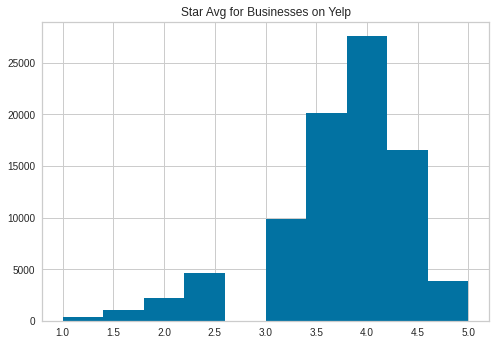

In [20]:
df.biz_star.hist()
plt.title('Star Avg for Businesses on Yelp')
plt.show()

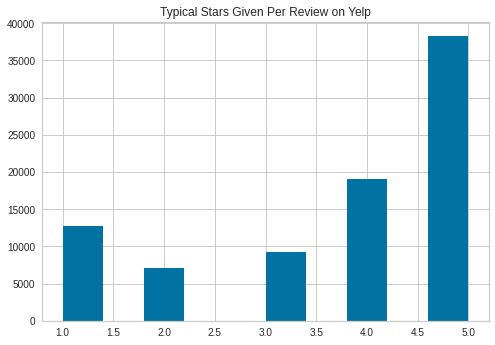

In [25]:
df.cur_review_star.hist()
plt.title('Typical Stars Given Per Review on Yelp')
plt.show()

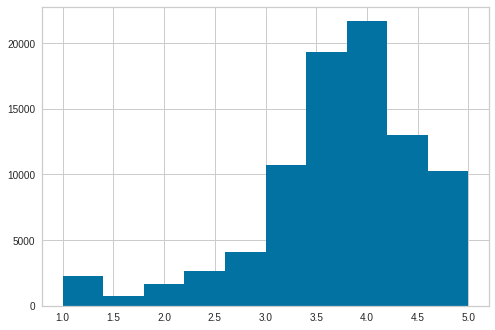

In [22]:
df.user_avg_star.hist()

In [23]:
print(df.star_diff.min())
df.star_diff.max()

-4.0


2.023121387283237

## Dimension Reduce by category filters
- Food
- Beauty

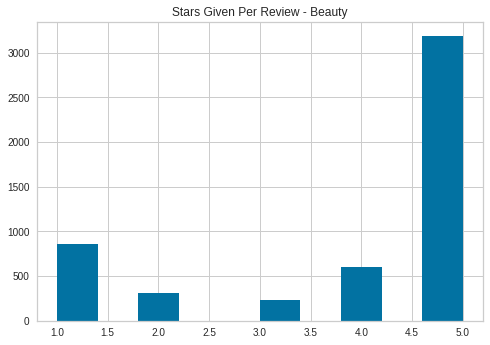

In [37]:
beauty_df = df[df.clean_cats.str.contains(pat = 'beauty')]

beauty_df.cur_review_star.hist()
plt.title("Stars Given Per Review - Beauty")
plt.show()

In [30]:
beauty_df.head(2)

,review_id,user_id,business_id,text,city,cur_review_star,user_rev_sum,biz_name,user_avg_star,biz_star,biz_rev_sum,rev_fb,clean_cats,star_diff,fb_ratio
5514688,80I2oxJmECdMDBWY1sv8oQ,GmKC7H7w-egvATrz9zF6fA,iO-m-gnFT6ScRWWx--OI6g,I booked an hour-long relaxing massage with An...,Somerville,4.0,83,Massage Therapy Works,3.47,4.5,257.0,0,acupuncture beauty health massage massage medi...,-0.144092,0.074576
16578,cJa51G_zt9Kf7DAIhjhPtw,M9PmwTEq-dVnbjqvhCNrKw,XU9WPde-PXNOGQsTPp0AfA,New owners....everything is new and clean\nGre...,Winchester,5.0,50,T & K Nail,4.16,3.0,34.0,2,beauty nail salons spas,0.480769,4.095611


In [31]:
rest_df = df[df.clean_cats.str.contains(pat = 'restaurant|food')]
len(rest_df)

60811

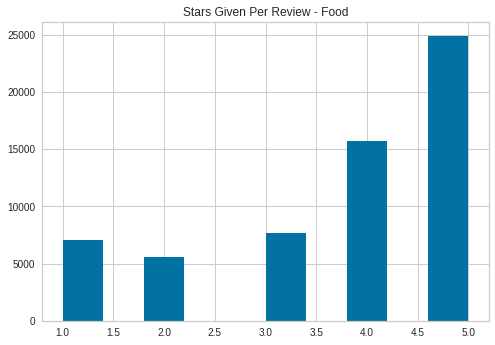

In [32]:
rest_df.cur_review_star.hist()
plt.title("Stars Given Per Review - Food")
plt.show()

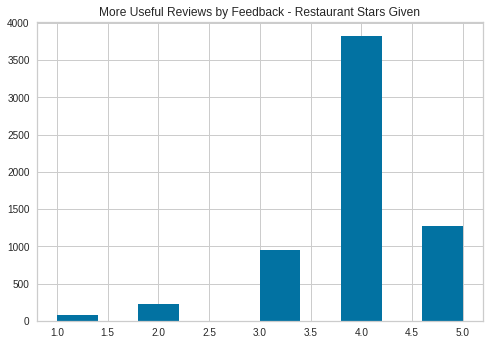

In [38]:
top_r_revs = rest_df[rest_df['fb_ratio'] >= 39]
top_r_revs.cur_review_star.hist()
plt.title("More Useful Reviews by Feedback - Restaurant Stars Given")
plt.show()

In [34]:
hotel_df = df[df.clean_cats.str.contains(pat = 'hotel')]
len(hotel_df)

3550

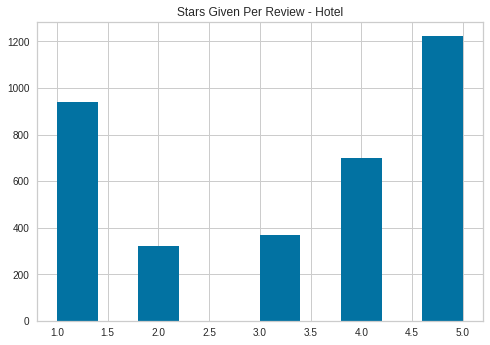

In [36]:
hotel_df.cur_review_star.hist()
plt.title("Stars Given Per Review - Hotel")
plt.show()

In [39]:
five_cities = df.city.value_counts().head(5).reset_index()
five_cities['index'].values # top 5 cities for review amounts

array(['Austin', 'Portland', 'Atlanta', 'Boston', 'Orlando'], dtype=object)

In [40]:
top_c = df.loc[df['city'].isin(five_cities['index'].values)]
top_c.clean_cats.value_counts().head(10) # top 10 categories by freq in top 5 cities

mexican restaurants                                                 687
event hotels hotels planning services travel                        349
bars japanese restaurants sushi                                     312
italian restaurants                                                 297
apartments estate home real services                                297
coffee food tea                                                     290
pizza restaurants                                                   268
event event hotels hotels planning services spaces travel venues    266
italian pizza restaurants                                           242
restaurants thai                                                    241
Name: clean_cats, dtype: int64

# Notes -
- reduce dimensionality
  - can do umap style
  - can remove words not in dictionary


Notes with Reza - 
from nltk.corpus import words as nltk_words

dictionary = dict.fromkeys(nltk_words.words(), None)

def spellchk(word): try: if dictionary[word.lower()] == None: return True except KeyError: return False

def no_number_preprocessor(tokens): r = re.sub('(\d)+', 'NUM', tokens.lower()) # This alternative just removes numbers: # r = re.sub('(\d)+', '', tokens.lower()) return r

def remove_non_ascii(text): return ''.join(i for i in text if ord(i)<128)


- Try topic modeling clusters - then analyze in a df. 